In [2]:
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize, Bounds, fmin_cg
from bayes_opt import BayesianOptimization
from skopt import gp_minimize
from deap import base, creator, tools, algorithms
import random

from matplotlib import pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal

import datetime

# Main idea
1) Exploits Volatility lags behind price movements (due to the rolling nature of variance)
2) Volatility overreacts or underreacts relative to price changes

Arbitrage Opportunity: mispricings caused by lags or overreactions in volatility relative to equity movements.

# Trading logic
We look at the S&P 500(GSPC) and it's volatility index (VIX), calculate the price ratio VIX/GSPC and do a rolling z-scorce.

When volatility lag behind price -> z-scorece become low -> long VIX short GSPC

When volatility over react -> z-scorece become high -> short VIX long GSPC

# Small complication 
Since we cannot directlt trade the index, we need some proxy, such as future or index tracking ETF.

Ideally we would want to use future as:
1) No borrowing fees for short positions
2) Lower transaction costs for larger positions
3) Higher capital efficiency through leverage

We can generate more alpha using future in priciple. However, there are also some extra cost such as
1) Contract Rolling
2) Mismatch between futures expirations

If the future data is not avaliabe, we will use the ETF: VOO and VXX for estimation.

In [13]:
def get_futures_data(start_date, end_date):
    indexes = ['^GSPC', '^VIX']
    
    # Try to download futures data
    try:
        futures = ['ES=F', 'VX18/K5']
        df = yf.download(indexes + futures, start=start_date, end=end_date)
        
        # Check if we got valid data for VX=F
        if 'VX=F' in df['Close'].columns and not df['Close']['VX=F'].isnull().all():
            close_price = df['Close']
            close_price.columns = [col.replace('^', '') for col in close_price.columns]
            close_price = close_price.rename(columns={'ES=F': 'ES', 'VX=F': 'VX'})
            return close_price
    except:
        pass
    
    # Fallback to ETFs if futures data not available
    etfs = ['VOO', 'VXX']
    df = yf.download(indexes + etfs, start=start_date, end=end_date).dropna()
    close_price = df['Close']
    close_price.columns = [col.replace('^', '') for col in close_price.columns]
    close_price = close_price.rename(columns={'VOO': 'ES', 'VXX': 'VX'})
    
    print("Using ETF data as proxy for futures")
    return close_price


end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=3600)
price_data = get_futures_data(start_date, end_date)

[**********************50%                       ]  2 of 4 completedFailed to get ticker 'VX18/K5' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  4 of 4 completed

1 Failed download:
['VX18/K5']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  4 of 4 completed

Using ETF data as proxy for futures


In [128]:
def Initialize_with_para(price, para):
    lookback_period = para['lookback_period']
    lookback_period = int(lookback_period)
    
    returns = price.pct_change().dropna()

    vix_ma = price['VIX'].rolling(window=lookback_period).mean()
    vix_std = price['VIX'].rolling(window=lookback_period).std()
    vix_zscore = (price['VIX'] - vix_ma) / vix_std
    
    vix_spx_ratio = price['VIX'] / price['GSPC']
    vix_spx_ratio_ma = vix_spx_ratio.rolling(window=lookback_period).mean()
    vix_spx_ratio_std = vix_spx_ratio.rolling(window=lookback_period).std()
    vix_spx_ratio_zscore = (vix_spx_ratio - vix_spx_ratio_ma) / vix_spx_ratio_std
    
    return pd.DataFrame({
        'ES': price['ES'],
        'VX': price['VX'],
        'ES_ret': returns['ES'],
        'VX_ret': returns['VX'],
        'VIX_Zscore': vix_zscore,
        'VIX_SPX_ratio_Zscore': vix_spx_ratio_zscore
    })


guess_para = {'lookback_period': 20, 'z_threshold_low':1.1, 'z_threshold_high':3.0, 'position_size':0.5}

data = Initialize_with_para(price_data, guess_para)

In [130]:
def generate_signals(data, para, use_ratio=True):
    z_threshold_low = para['z_threshold_low']
    z_threshold_high = para['z_threshold_high']
    lookback_period = para['lookback_period']
    position_size = para['position_size']
    
    df = data.copy()
    
    signal_col = 'VIX_SPX_ratio_Zscore' if use_ratio else 'VIX_Zscore'
    
    df['VX_pos'] = 0.0
    df['ES_pos'] = 0.0
    
    # Long volatility, short equity (Z-score < low threshold)
    df.loc[df[signal_col] < -z_threshold_low, 'VX_pos'] = position_size
    df.loc[df[signal_col] < -z_threshold_low, 'ES_pos'] = -position_size
    
    # Short volatility, long equity (Z-score > high threshold)
    df.loc[df[signal_col] > z_threshold_high, 'VX_pos'] = -position_size
    df.loc[df[signal_col] > z_threshold_high, 'ES_pos'] = position_size
    
    return df

data = generate_signals(data, guess_para)

In [132]:
data

,ES,VX,ES_ret,VX_ret,VIX_Zscore,VIX_SPX_ratio_Zscore,VX_pos,ES_pos
Date,,,,,,,,
2018-01-25,230.739624,1770.239990,NaN,NaN,NaN,NaN,0.0,0.0
2018-01-26,233.425201,1770.239990,0.011639,0.000000,NaN,NaN,0.0,0.0
2018-01-29,231.812134,1893.119995,-0.006910,0.069414,NaN,NaN,0.0,0.0
2018-01-30,229.339233,1955.199951,-0.010668,0.032792,NaN,NaN,0.0,0.0
2018-01-31,229.551971,1961.599976,0.000928,0.003273,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-04-02,518.909973,50.090000,0.006029,-0.027001,-0.059601,-0.077395,0.0,0.0
2025-04-03,494.160004,62.490002,-0.047696,0.247554,2.348856,2.499896,0.0,0.0
2025-04-04,465.519989,74.849998,-0.057957,0.197792,3.557549,3.658641,-0.5,0.5


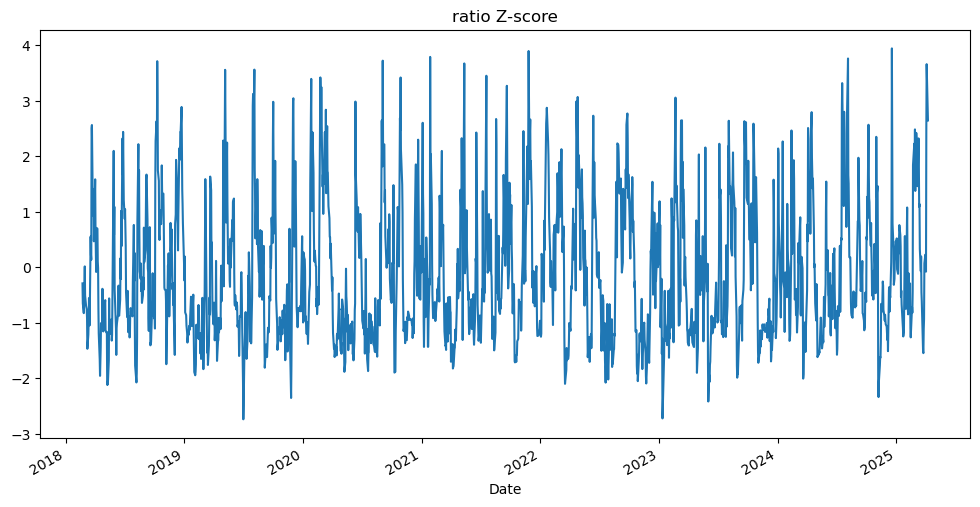

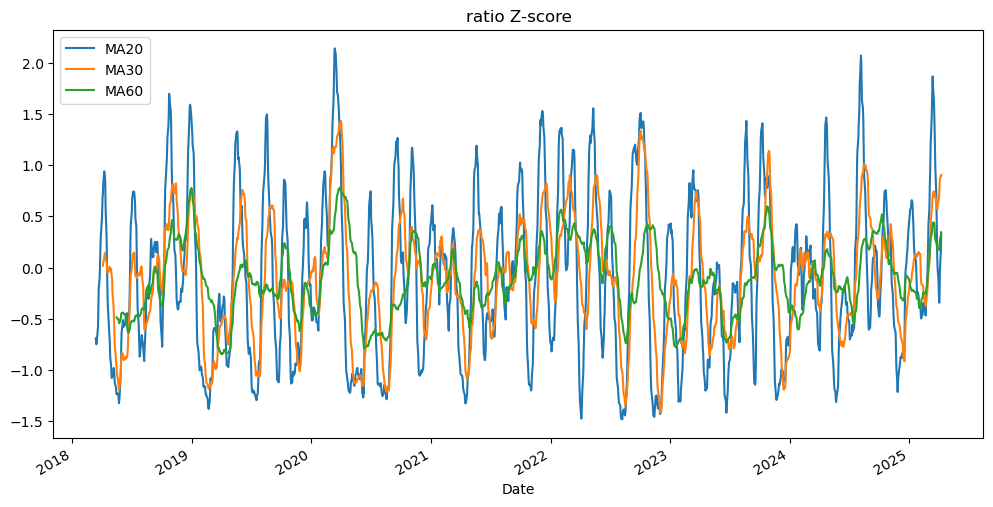

In [108]:
data['VIX_SPX_ratio_Zscore'].plot(title='ratio Z-score',figsize=(12,6))
plt.show()

data['VIX_SPX_ratio_Zscore'].rolling(15).mean().plot(title='ratio Z-score',figsize=(12,6),label="MA20")
data['VIX_SPX_ratio_Zscore'].rolling(30).mean().plot(title='ratio Z-score',figsize=(12,6),label="MA30")
data['VIX_SPX_ratio_Zscore'].rolling(60).mean().plot(title='ratio Z-score',figsize=(12,6),label="MA60")
plt.legend()
plt.show()

In [110]:
def backtest(data, initial_capital=100000.0, commission=0.001):
    df = data.copy()
    
    df['capital'] = initial_capital
    df['VX_dollars'] = 0.0
    df['ES_dollars'] = 0.0
    
    if len(df) > 0:
        df.loc[df.index[0], 'VX_dollars'] = df.loc[df.index[0], 'VX_pos'] * initial_capital
        df.loc[df.index[0], 'ES_dollars'] = df.loc[df.index[0], 'ES_pos'] * initial_capital
    
    for i in range(1, len(df)):
        prev_capital = df.loc[df.index[i-1], 'capital']

        # 1-day lag to avoid look-ahead bias
        vx_pnl = df.loc[df.index[i-1], 'VX_dollars'] * df.loc[df.index[i], 'VX_ret']
        es_pnl = df.loc[df.index[i-1], 'ES_dollars'] * df.loc[df.index[i], 'ES_ret']
        
        new_vx_dollars = df.loc[df.index[i], 'VX_pos'] * prev_capital
        new_es_dollars = df.loc[df.index[i], 'ES_pos'] * prev_capital
        
        vx_change = abs(new_vx_dollars - df.loc[df.index[i-1], 'VX_dollars'])
        es_change = abs(new_es_dollars - df.loc[df.index[i-1], 'ES_dollars'])
        commission_cost = (vx_change + es_change) * commission

        daily_pnl = vx_pnl + es_pnl - commission_cost
        df.loc[df.index[i], 'capital'] = prev_capital + daily_pnl
        
        current_capital = df.loc[df.index[i], 'capital']
        df.loc[df.index[i], 'VX_dollars'] = df.loc[df.index[i], 'VX_pos'] * current_capital
        df.loc[df.index[i], 'ES_dollars'] = df.loc[df.index[i], 'ES_pos'] * current_capital
    
    df['daily_pnl'] = df['capital'].diff()
    df['strat_ret'] = df['daily_pnl'] / df['capital'].shift(1)
    
    df['cum_ES_ret'] = (1 + df['ES_ret']).cumprod() - 1
    df['cum_VX_ret'] = (1 + df['VX_ret']).cumprod() - 1
    df['cum_strat_ret'] = (df['capital'] / initial_capital) - 1
    
    df = df.dropna()
    
    return df

# For future trading only (different way of calculating commission)

def backtest_future(data, initial_capital=100000.0, commission_per_contract=2.0, contract_size_es=50, contract_size_vx=1000):
    df = data.copy()
    
    df['capital'] = initial_capital
    
    df['ES_contract_value'] = df['ES'] * contract_size_es
    df['VX_contract_value'] = df['VX'] * contract_size_vx
    
    df['ES_contracts'] = (df['ES_pos'] * df['capital'].shift(1).fillna(initial_capital) / df['ES_contract_value']).round()
    df['VX_contracts'] = (df['VX_pos'] * df['capital'].shift(1).fillna(initial_capital) / df['VX_contract_value']).round()
    
    # 1-day lag to avoid look-ahead bias
    df['ES_dollar_pnl'] = df['ES_contracts'].shift(1) * contract_size_es * df['ES_ret']
    df['VX_dollar_pnl'] = df['VX_contracts'].shift(1) * contract_size_vx * df['VX_ret']
    
    df['ES_contract_change'] = df['ES_contracts'].diff().abs()
    df['VX_contract_change'] = df['VX_contracts'].diff().abs()
    df['commission_dollars'] = (df['ES_contract_change'] + df['VX_contract_change']) * commission_per_contract
    
    df['daily_pnl'] = df['ES_dollar_pnl'] + df['VX_dollar_pnl'] - df['commission_dollars']
    
    for i in range(1, len(df)):
        df.loc[df.index[i], 'capital'] = df.loc[df.index[i-1], 'capital'] + df.loc[df.index[i], 'daily_pnl']
    
    df['strat_ret'] = df['daily_pnl'] / df['capital'].shift(1)
    
    df['cum_ES_ret'] = (1 + df['ES_ret']).cumprod() - 1
    df['cum_VX_ret'] = (1 + df['VX_ret']).cumprod() - 1
    df['cum_strat_ret'] = (df['capital'] / initial_capital) - 1
    
    df = df.dropna()
    
    return df

In [112]:
def calculate_performance(returns):

    if len(returns) == 0:
        return {"Error": "No returns data available"}
        
    total_return = (1 + returns).prod() - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol if annual_vol != 0 else 0
    
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns / peak) - 1
    max_drawdown = drawdown.min()
    
    mean_return = returns.mean()
    
    return {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown,
        "Mean Return": mean_return
    }

In [120]:
def optimize_parameters_bayesian(price_data, n_iterations=50, n_init_points=10,
                               target_rfr=0.04, initial_capital=100000.0, 
                               commission=0.0001, use_ratio=True):
    
    # Define objective function for the optimizer
    def objective(z_threshold_low, z_threshold_high, lookback_period, position_size):
        # Handling the constraint: z_threshold_low must be < z_threshold_high
        if z_threshold_low >= z_threshold_high:
            return -100  # Large penalty for invalid configurations
        
        params = {
            'z_threshold_low': z_threshold_low,
            'z_threshold_high': z_threshold_high,
            'lookback_period':  lookback_period,
            'position_size': position_size
        }
        
        # Run backtest with these parameters
        temp_data = Initialize_with_para(price_data, params)
        signals_data = generate_signals(temp_data, params, use_ratio)
        
        backtest_results = backtest(signals_data, 
                                  initial_capital=initial_capital, 
                                  commission=commission)
        
        if len(backtest_results) > 0:
            returns = backtest_results['strat_ret']
            
            if len(returns) == 0 or returns.std() == 0:
                return -100  # Large penalty for invalid configurations
            else:
                mean_return = returns.mean() * 252
                annual_vol = returns.std() * np.sqrt(252)
                adj_annual_return = mean_return - target_rfr
                sharpe = (adj_annual_return)/(annual_vol)
                return sharpe
        
        return -100  # Large penalty for invalid configurations
    
    # Define parameter bounds
    pbounds = {
        'z_threshold_low': (-2.0, 0.0),
        'z_threshold_high': (3.0, 5.0),
        'lookback_period': (15, 60),
        'position_size': (0.05,0.99)
    }
    
    # Initialize Bayesian Optimization
    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,
        random_state=42,
        verbose=2  # Prints out when a new maximum is found
    )
    
    print("\nRunning Bayesian Optimization...")
    # Perform optimization
    optimizer.maximize(
        init_points=n_init_points,   # Number of initial random explorations
        n_iter=n_iterations          # Number of optimization iterations
    )
    
    # Get the best parameters
    best_params_dict = optimizer.max['params']
    
    # Convert to the format expected by our strategy
    best_params = {
        'z_threshold_low': best_params_dict['z_threshold_low'],
        'z_threshold_high': best_params_dict['z_threshold_high'],
        'lookback_period' : best_params_dict['lookback_period'],
        'position_size' : best_params_dict['position_size'],
        'log_sharpe_ratio': optimizer.max['target']
    }
    
    return best_params

# Run the optimization
print("\nOptimizing strategy parameters using Bayesian Optimization...")
best_params = optimize_parameters_bayesian(price_data, n_iterations=10, n_init_points=2)
print(f"\nBest parameters found:")
print(f"Z-Score Low Threshold: {best_params['z_threshold_low']:.4f}")
print(f"Z-Score High Threshold: {best_params['z_threshold_high']:.4f}")
print(f"Log Sharpe Ratio: {best_params['log_sharpe_ratio']:.4f}")


Optimizing strategy parameters using Bayesian Optimization...

Running Bayesian Optimization...
|   iter    |  target   | lookba... | positi... | z_thre... | z_thre... |
-------------------------------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/bayes_opt/target_space.py:344: UserWarning: You're attempting to register an np.ndarray. Currently, the optimizer internally sorts parameters by key and expects any registered array to respect this order. In future versions this behaviour will change and the order as given by the pbounds dictionary will be used. If you wish to retain sorted parameters, please manually sort your pbounds dictionary before constructing the optimizer.
  warn(msg, stacklevel=1)


| 1         | -0.3653   | 31.85     | 0.9437    | 4.464     | -0.8027   |
| 2         | -0.6902   | 22.02     | 0.1966    | 3.116     | -0.2676   |
| 3         | -0.4884   | 31.83     | 0.9378    | 4.283     | -0.657    |
| 4         | -1.68     | 17.21     | 0.06737   | 4.201     | -0.5523   |
| 5         | -0.6069   | 32.95     | 0.8576    | 4.914     | -1.886    |
| 6         | -0.5618   | 30.77     | 0.6455    | 4.996     | -1.92     |
| 7         | -0.779    | 33.38     | 0.3125    | 4.984     | -0.05748  |
| 8         | -0.8765   | 30.82     | 0.1448    | 4.966     | -0.3811   |
| 9         | -0.4351   | 31.72     | 0.9148    | 4.162     | -1.984    |
| 10        | -0.5312   | 25.04     | 0.6884    | 3.171     | -1.811    |
| 11        | -0.6599   | 25.16     | 0.3392    | 4.742     | -0.6264   |
| 12        | -0.5074   | 26.93     | 0.524     | 3.152     | -1.649    |

Best parameters found:
Z-Score Low Threshold: -0.8027
Z-Score High Threshold: 4.4640
Log Sharpe Ratio: -0.3653


In [122]:
optimized_data = Initialize_with_para(price_data, best_params)
optimized_data = generate_signals(optimized_data, best_params)
optimized_results = backtest(optimized_data)

optimized_performance = calculate_performance(optimized_results['strat_ret'])
print("\nOptimized Performance Metrics:")
for metric, value in optimized_performance.items():
    print(f"{metric}: {value:.2e}")


Optimized Performance Metrics:
Total Return: -9.40e-01
Annual Return: -3.28e-01
Annual Volatility: 5.92e-01
Sharpe Ratio: -5.54e-01
Max Drawdown: -9.80e-01
Mean Return: -9.09e-04


In [124]:
def visualize_strategy(results, params, use_ratio=True):
    plt.figure(figsize=(14, 6))
    plt.plot(results.index, results['cum_strat_ret'], label='Strategy')
    plt.title('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 6))
    signal_col = 'VIX_SPX_ratio_Zscore' if use_ratio else 'VIX_Zscore'
    plt.plot(results.index, results[signal_col], label=signal_col)
    plt.axhline(y=params['z_threshold_high'], color='r', linestyle='--', label='Upper Threshold')
    plt.axhline(y=-params['z_threshold_low'], color='g', linestyle='--', label='Lower Threshold')
    
    long_vx_points = results[results['VX_pos'] > 0].index
    short_vx_points = results[results['VX_pos'] < 0].index
    
    plt.scatter(long_vx_points, results.loc[long_vx_points, signal_col], 
                marker='^', color='green', s=20, label='Long VX/Short ES')
    plt.scatter(short_vx_points, results.loc[short_vx_points, signal_col], 
                marker='v', color='red', s=20, label='Short VX/Long ES')
    
    plt.title(f'{signal_col} with Thresholds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

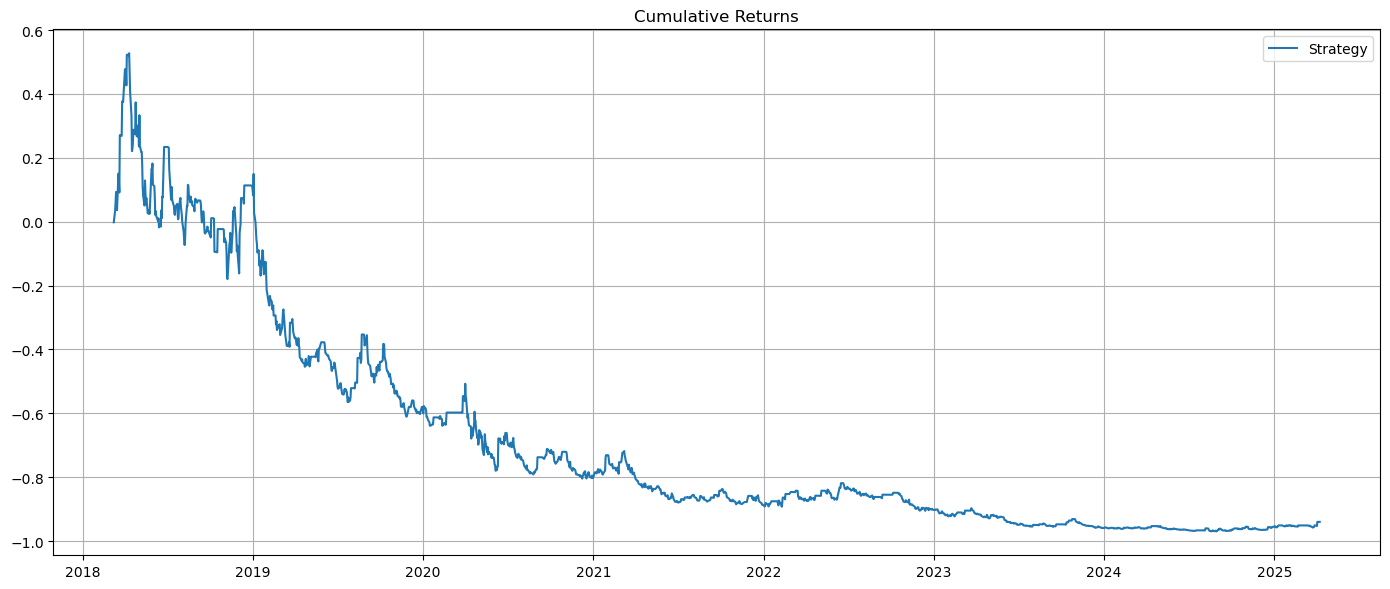

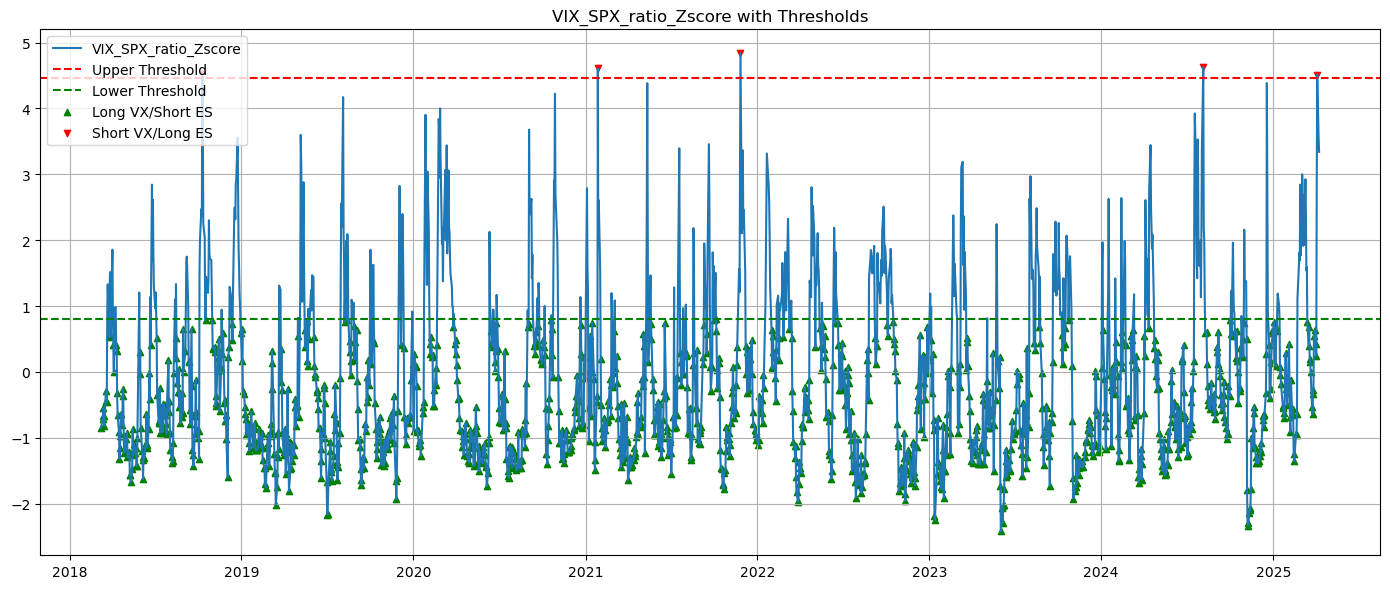

In [126]:
visualize_strategy(optimized_results, best_params)